In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import copy
import os

import sys
import time
from scipy.stats import norm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from helper import df_to_latex, fig_path, set_figsize, tab_path

# Import code from src
sys.path.insert(0, '../src/')
import vmc 


# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

fontsize = "large"

params = {"font.family": "serif",
          "font.sans-serif": ["Computer Modern"],
          "axes.labelsize": fontsize,
          "legend.fontsize": fontsize,
          "xtick.labelsize": fontsize,
          "ytick.labelsize": fontsize,
          "legend.handlelength": 2
          }


plt.rcParams.update(params)
plt.rc('text', usetex=True)

"""
# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

# Set fontsizes in figures
fontsize = 10
tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": fontsize,
    "font.size": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize-1,
    "ytick.labelsize": fontsize-1,
    'legend.handlelength': 2
}

plt.rcParams.update(tex_fonts)
"""
# Set figure size
width = 410 #360
figsize = set_figsize(width, fraction=1)

In [2]:
def exact_energy(N, dim, omega):
    return (omega * dim * N) / 2

def safe_initial_positions_no_interactions(wavefunction, alpha, N, dim, seed=None):
    rng = np.random.default_rng(seed=seed)
    positions = rng.random(size=(N, dim))

    # safe initialization
    wf2 = wavefunction.pdf(positions, alpha)
    while np.sum(wf2) <= 1e-14:
        positions *= 0.5
        wf2 = wavefunction.pdf(positions, alpha)

    return positions

def safe_initial_positions_w_interactions(wavefunction, alpha, N, dim, seed=None): 
    rng = np.random.default_rng(seed=seed)
    positions = rng.random(size=(N, dim))
    
    # safe initialization
    wf2 = wavefunction.pdf(positions, alpha)
    while np.sum(wf2) <= 1e-14: 
        positions *= 2.0
        wf2 = wavefunction.pdf(positions, alpha)
        
    return positions

def interact_initial_positions(wf, alpha, N, dim, a=0.00433):

    rng = np.random.default_rng()

    def corr_factor(r1, r2):
        rij = np.linalg.norm(r1 - r2)
        if rij <= a:
            return 0.
        else:
            return 1 - (a / rij)

    scale = 2.
    r = np.random.randn(N, dim) * scale
    #r = rng.random(size=(N, dim))

    rerun = True
    while rerun:
        rerun = False
        for i in range(N):
            for j in range(i + 1, N):
                corr = corr_factor(r[i, :], r[j, :])
                if corr == 0.:
                    print("corr=0 encountered")
                    rerun = True
                    r[i, :] = np.random.randn() * scale
                    r[j, :] = np.random.randn() * scale
        scale *= 1.5

    return r, scale

def get_mean_w_standard_error_grid_search(data, alphas): 
    data_dict = {"alpha": alphas, "energy": [], "standard_error":[],"standard_error_of_the_mean": []}
    for i, alpha in enumerate(alphas): 
        energies_alpha = data["energy"][data["alpha"]==alpha]
        standard_errors_alpha = data["standard_error"][data["alpha"]==alpha]
        mean_energy_alpha = np.mean(energies_alpha)
        standard_error = np.mean(standard_errors_alpha)
        standard_error_of_the_mean = np.std(standard_errors_alpha)/np.sqrt(len(standard_errors_alpha))
        data_dict["energy"].append(mean_energy_alpha)
        data_dict["standard_error"].append(standard_error)
        data_dict["standard_error_of_the_mean"].append(standard_error_of_the_mean)
        
    dataframe = pd.DataFrame(data=data_dict)
    return dataframe


## Finding ground state energy of non-interacting particles in elliptical potential

In [4]:
N = 10
dim = 3
omega = 1.0
initial_alpha = 0.5
wf = vmc.AEHOIB(N, dim, omega, a=0) # setting a=0, such that the bosons are point particles
sampler = vmc.Metropolis(wf)
nsamples = int(2**16)
initial_positions, scale = interact_initial_positions(wf, initial_alpha, N, dim)
start = time.time()
results = sampler.sample(nsamples, 
                        initial_positions, 
                        initial_alpha, 
                        nchains=1,
                        scale=1.0, 
                        warm=True, 
                        warmup_iter=20000, 
                        tune=True, 
                        tune_iter=30000, 
                        tune_interval=1000,
                        optimize=False,
                        max_iter=200000,
                        batch_size=2000,
                        gradient_method='adam',
                        eta=0.01,
                        tol_optim=1e-7,
                        )
end = time.time()
print("Sampler elapsed time:", end - start)
print(results)

wf = vmc.EHONIB()
initial_positions, scale = interact_initial_positions(wf, initial_alpha, N, dim)
start = time.time()
results_JAX = sampler.sample(nsamples, 
                            initial_positions, 
                            initial_alpha, 
                            nchains=1,
                            scale=1.0, 
                            warm=True, 
                            warmup_iter=20000, 
                            tune=True, 
                            tune_iter=30000, 
                            tune_interval=1000,
                            optimize=False,
                            max_iter=200000,
                            batch_size=2000,
                            gradient_method='adam',
                            eta=0.01,
                            tol_optim=1e-7,
                            )
end = time.time()
print("Sampler elapsed time:", end - start)
print(results_JAX)

Warm done
Tune done
Warm after tune done
Rewarming done
Sampling energy
Sampler elapsed time: 60.81979823112488
   nparticles  dim  alpha    energy  standard_error  accept_rate
0          10    3    0.5  24.14215             0.0     0.243057
Warm done
Tune done
Warm after tune done
Rewarming done
Sampling energy
Sampler elapsed time: 52.3468804359436
   nparticles  dim  alpha    energy  standard_error  accept_rate
0          10    3    0.5  24.14215             0.0      0.37616


#### Small analysis
$\alpha=0.5$ corresponds to the ground state for non-interacting particles. The ground state energy per particle is $\langle E\rangle/N = 2.414215$. 

## Interacting particles in elliptical potential

In [3]:
N = 10
dim = 3
omega = 1.0
initial_alpha = 0.5
wf = vmc.AEHOIB(N, dim, omega)
sampler = vmc.Metropolis(wf)
nsamples = int(2**20)
initial_positions, scale = interact_initial_positions(wf, initial_alpha, N, dim)
results_E10 = []
start = time.time()
results_E10 = sampler.sample(nsamples, 
                             initial_positions, 
                             initial_alpha, 
                             nchains=16,
                             scale=1.0, 
                             warm=True, 
                             warmup_iter=20000, 
                             tune=True, 
                             tune_iter=30000, 
                             tune_interval=1000,
                             optimize=True,
                             max_iter=400000,
                             batch_size=5000,
                             gradient_method='adam',
                             eta=0.01,
                            tol_optim=1e-8,
                            )
end = time.time()
print("Sampler elapsed time:", end - start)
df_N10_all = sampler.results_all
df_N10 = pd.concat(results_E10, ignore_index=True)
df_N10

Warm done
Warm done
Warm done
Warm done
Tune done
Tune done
Tune done
Tune done
Warm after tune done
Warm after tune done
Warm after tune done
Warm after tune done


Process ForkPoolWorker-2:
Process ForkPoolWorker-4:
Traceback (most recent call last):
Process ForkPoolWorker-3:
Traceback (most recent call last):
  File "/home/jeb/.local/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
Process ForkPoolWorker-1:
  File "/home/jeb/.local/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/home/jeb/.local/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jeb/.local/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jeb/.local/lib/python3.8/site-packages/multiprocess/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
Traceback (most recent call last):
  File "/home/jeb/.local/lib/python3.8/site-packages/multiprocess/pool.py", line 125, in worker
    result = (True, func(*args, **kwds

KeyboardInterrupt: 

Warm done
Warm done
Warm done
Warm done
Tune done
Tune done
Tune done
Tune done
Warm after tune done
Warm after tune done
Warm after tune done
Warm after tune done
Rewarming done
Sampling energy
Rewarming done
Sampling energy
Rewarming done
Sampling energy
Rewarming done
Sampling energy
Warm done
Warm done
Warm done
Warm done
Tune done
Tune done
Tune done
Tune done
Warm after tune done
Warm after tune done
Warm after tune done
Warm after tune done
Rewarming done
Sampling energy
Rewarming done
Sampling energy
Rewarming done
Sampling energy
Rewarming done
Sampling energy
Warm done
Warm done
Warm done
Warm done
Tune done
Tune done
Tune done
Tune done
Warm after tune done
Warm after tune done
Warm after tune done
Warm after tune done
Rewarming done
Sampling energy
Rewarming done
Sampling energy
Rewarming done
Sampling energy
Rewarming done
Sampling energy
Warm done
Warm done
Warm done
Warm done
Tune done
Tune doneTune done

Tune done
Warm after tune done
Warm after tune done
Warm after tun

Process ForkPoolWorker-5:
Process ForkPoolWorker-6:
Process ForkPoolWorker-7:
Process ForkPoolWorker-8:
  File "/home/jeb/.local/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jeb/.local/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/home/jeb/.local/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jeb/.local/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/home/jeb/.local/lib/python3.8/site-packages/multiprocess/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
Traceback (most recent call last):
  File "/home/jeb/.local/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._arg

In [19]:
energy_mean = df_N10["energy"].mean()
error_mean = df_N10["standard_error"].mean()
alpha_mean = df_N10["alpha"].mean()
alpha_std = df_N10["alpha"].std()
print(f"VMC energy: {energy_mean}")
print(f"VMC error: {error_mean}")
print(f"VMC optimal alpha: {alpha_mean}+-{alpha_std}")

VMC energy: 24.45972859507188
VMC error: 0.0005365271684803576
VMC optimal alpha: 0.49967474881599716+-0.001055636691325557


In [17]:
df_N10_all

,nparticles,dim,scale,eta,alpha,energy,standard_error,accept_rate,nsamples,total_cycles,warmup_cycles,tuning_cycles,optimize_cycles
0,10,3,0.250000,0.1,0.498827,24.442265,0.000406,0.249551,1048576,1516576,533000,3000,380000
1,10,3,0.194872,0.1,0.499132,24.471879,0.000424,0.380171,1048576,1522576,545000,3000,380000
2,10,3,0.214359,0.1,0.497556,24.460220,0.000507,0.331434,1048576,1525576,551000,3000,380000
3,10,3,0.214359,0.1,0.499269,24.459964,0.000429,0.328551,1048576,1523576,547000,3000,380000


NameError: name 'df_N10' is not defined

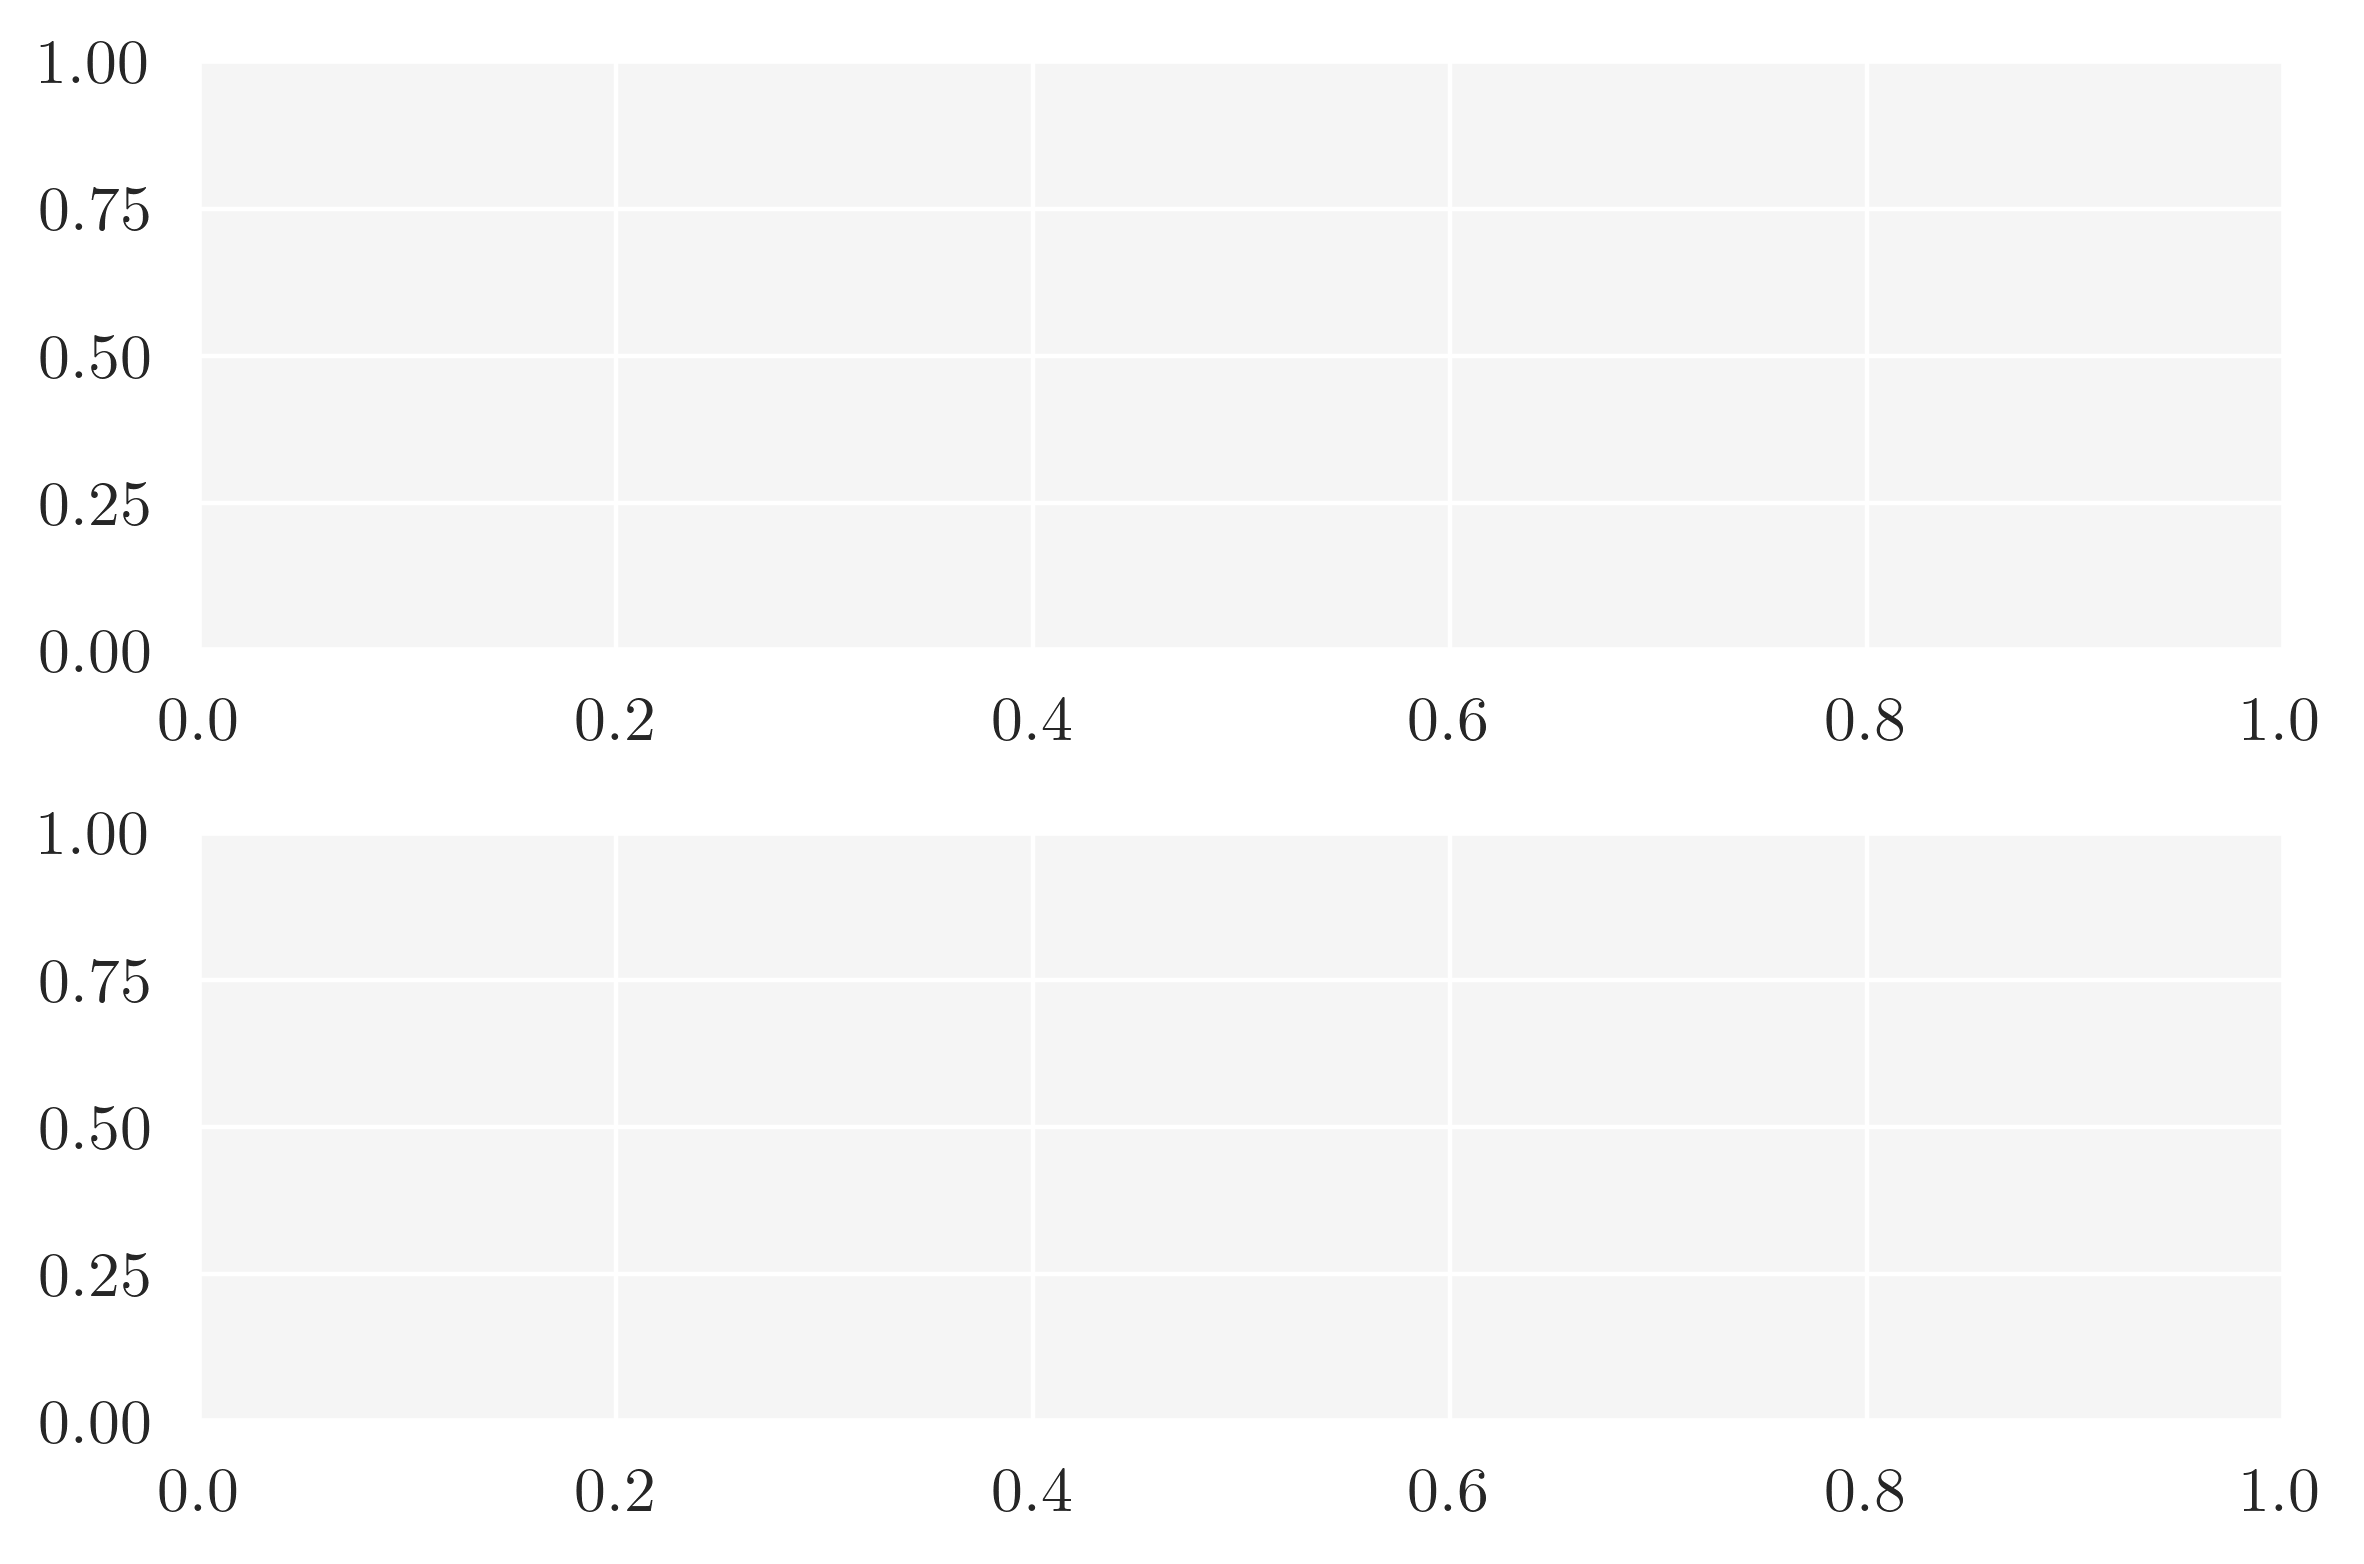

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 4), tight_layout=True, dpi=200)

sns.boxplot(data=df_N10, x="energy", color="C0", fliersize=0, ax=axes[0])
sns.swarmplot(data=df_N10, x="energy", color=".25", ax=axes[0])
axes[0].set(xlabel="Energy")

sns.boxplot(data=df_N10, x="standard_error", color="C1", fliersize=0, ax=axes[1])
sns.swarmplot(data=df_N10, x="standard_error", color=".25", ax=axes[1])
axes[1].set(xlabel="Standard Error")

fig.savefig(fig_path("boxplot_E_N10_metropolis.pdf"), bbox_inches='tight')

plt.show()

In [21]:
N = 50
dim = 3
omega = 1.0
initial_alpha = 0.5
wf = vmc.AEHOIB(N, dim, omega)
sampler = vmc.Metropolis(wf)
nsamples = int(2**18)
initial_positions, scale = interact_initial_positions(wf, initial_alpha, N, dim)
start = time.time()
results = sampler.sample(nsamples, 
                        initial_positions, 
                        initial_alpha, 
                        nchains=16,
                        scale=1.0, 
                        warm=True, 
                        warmup_iter=20000, 
                        tune=True, 
                        tune_iter=30000, 
                        tune_interval=1000,
                        optimize=True,
                        max_iter=500000,
                        batch_size=2000,
                        gradient_method='adam',
                        eta=0.01,
                        tol_optim=1e-8,
                        )
end = time.time()
print("Sampler elapsed time:", end - start)
print(results)

Sampler elapsed time: 1987.2253048419952
   nparticles  dim     alpha      energy  standard_error  accept_rate
0          50    3  0.512692  128.641933        0.044726     0.313393
1          50    3  0.501411  128.321151        0.014859     0.270054
2          50    3  0.498878  128.507781        0.015417     0.326302
3          50    3  0.492616  128.557249        0.024056     0.321404


In [22]:
df_N50 = pd.DataFrame(data=results)
energy_mean = df_N50["energy"].mean()
error_mean = df_N50["standard_error"].mean()
alpha_mean = df_N50["alpha"].mean()
alpha_std = df_N50["alpha"].std()
print(f"VMC energy: {energy_mean}")
print(f"VMC error: {error_mean}")
print(f"VMC optimal alpha: {alpha_mean}+-{alpha_std}")

VMC energy: 128.50702834128964
VMC error: 0.024764523181279568
VMC optimal alpha: 0.5013989559448111+-0.008387089130498104


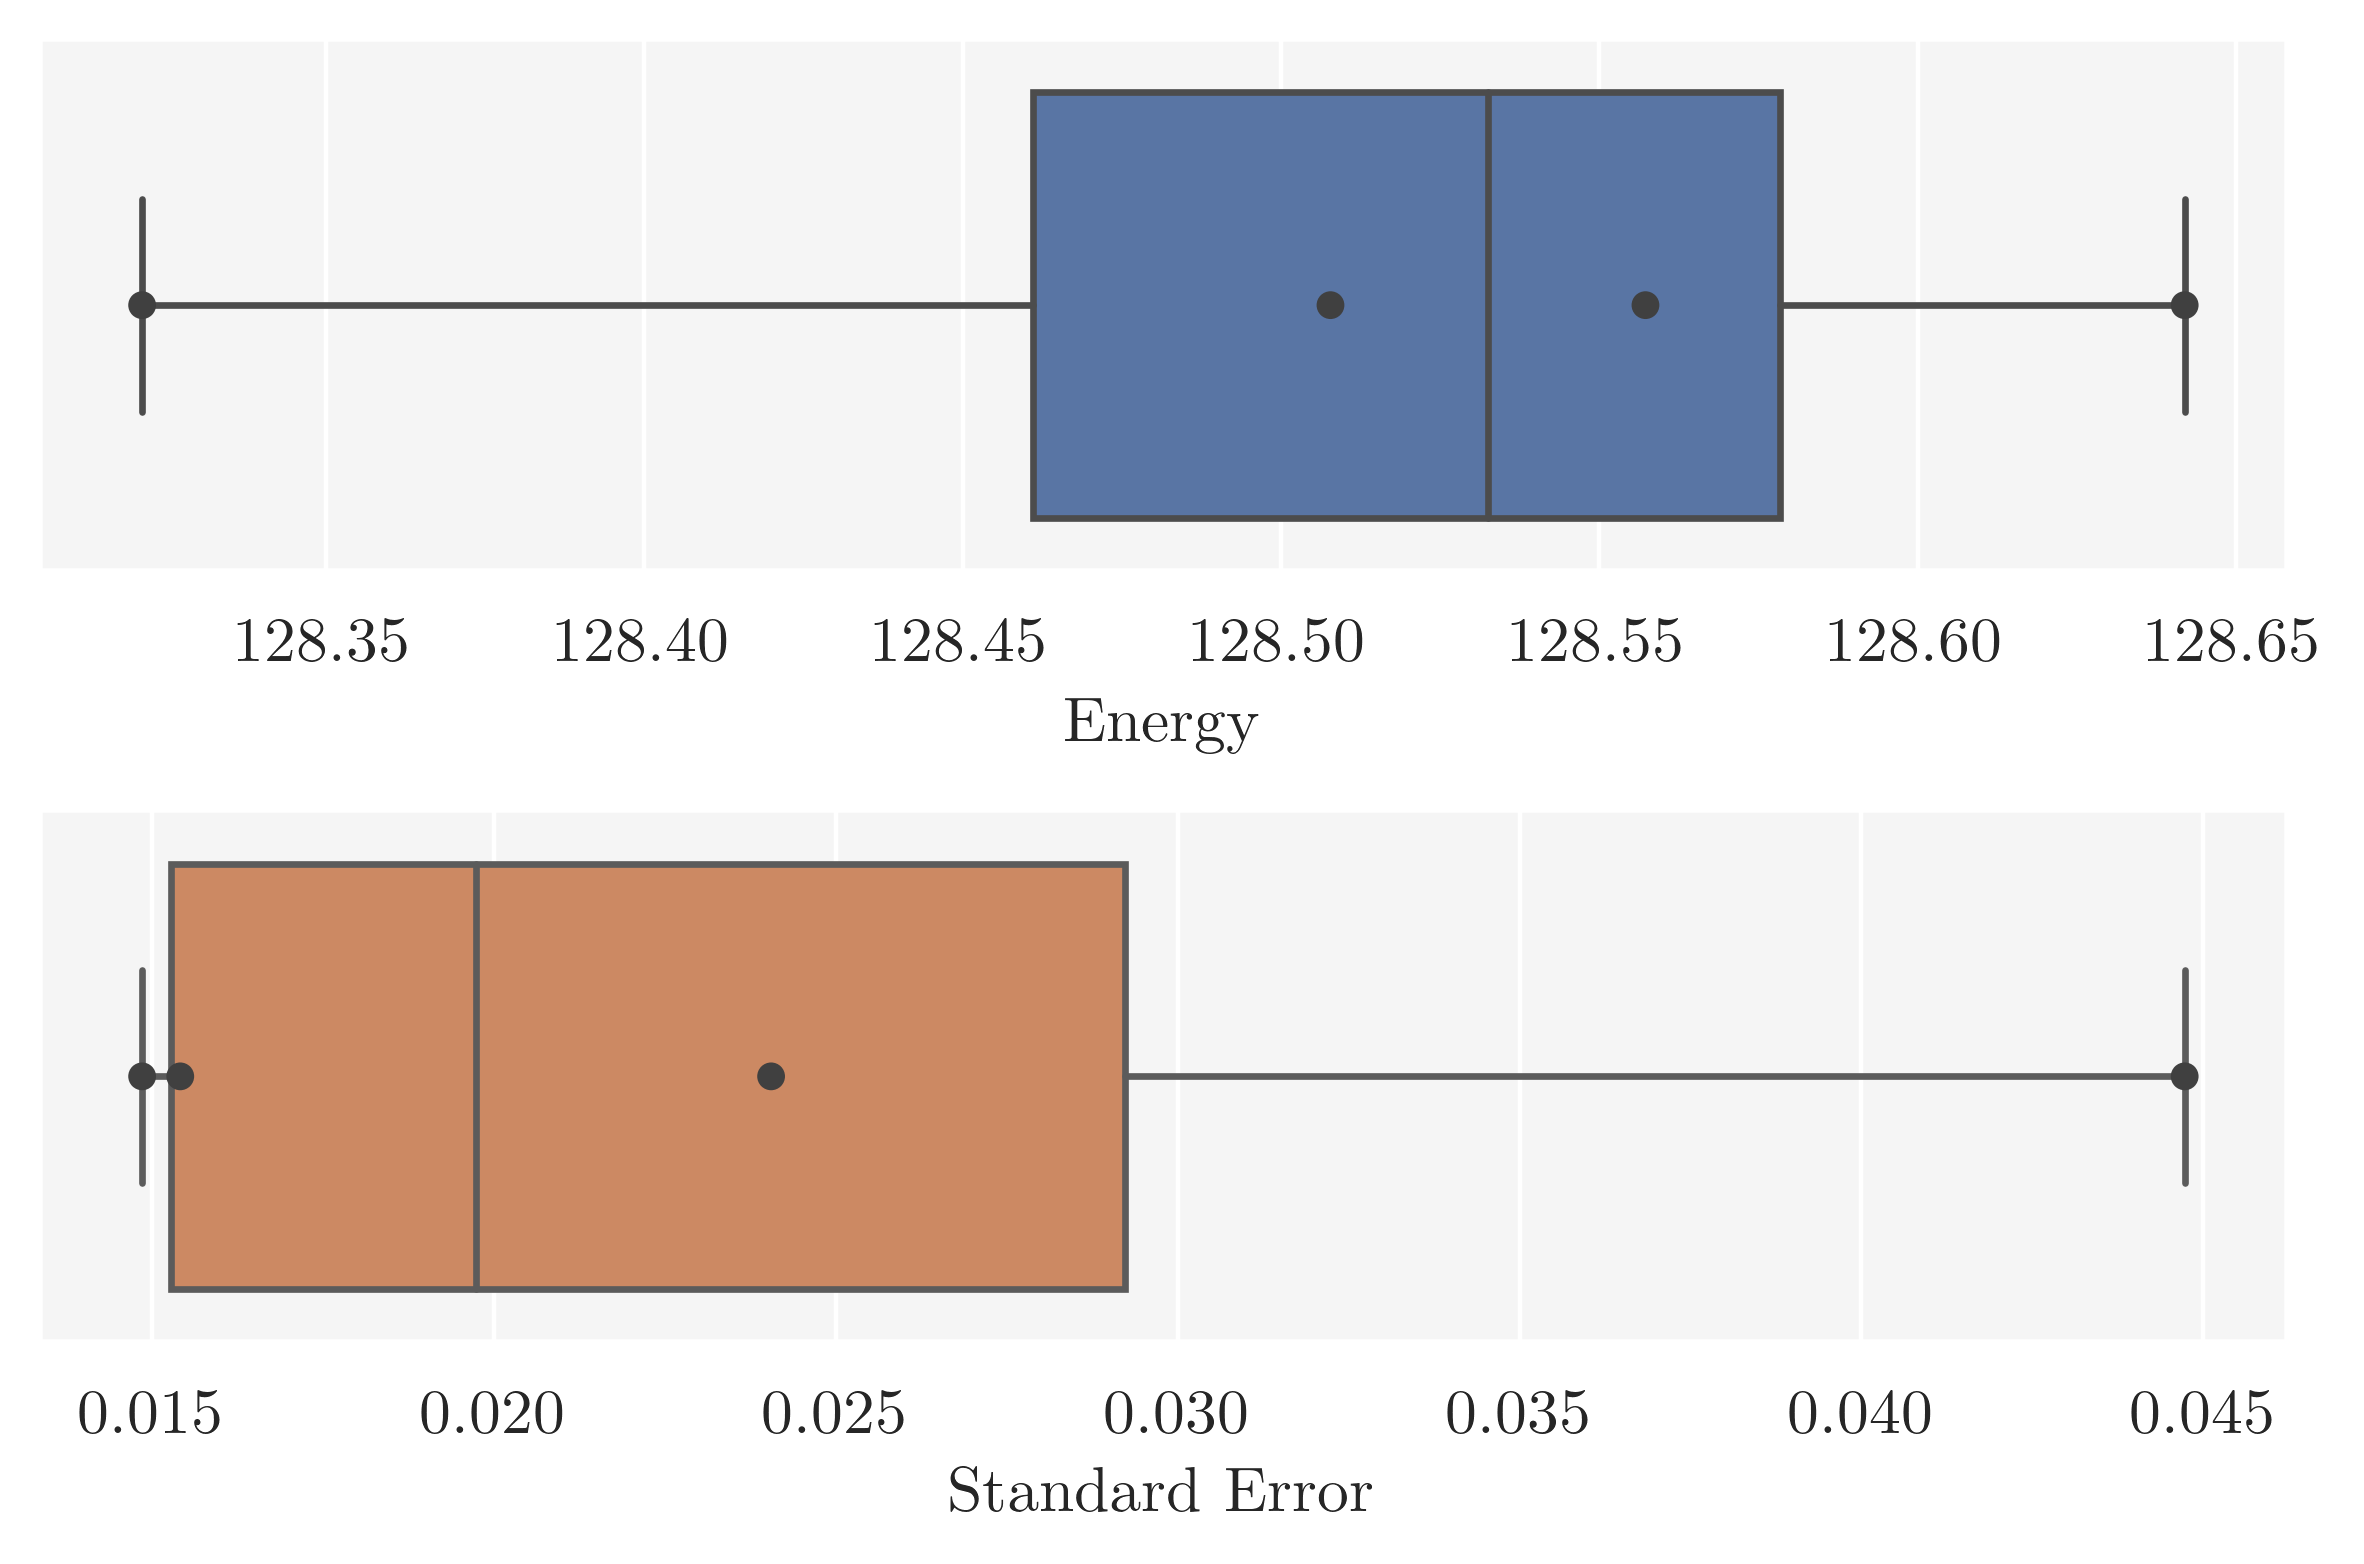

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 4), tight_layout=True, dpi=200)

sns.boxplot(data=df_N50, x="energy", color="C0", fliersize=0, ax=axes[0])
sns.swarmplot(data=df_N50, x="energy", color=".25", ax=axes[0])
axes[0].set(xlabel="Energy")

sns.boxplot(data=df_N50, x="standard_error", color="C1", fliersize=0, ax=axes[1])
sns.swarmplot(data=df_N50, x="standard_error", color=".25", ax=axes[1])
axes[1].set(xlabel="Standard Error")

fig.savefig(fig_path("boxplot_E_N50_metropolis.pdf"), bbox_inches='tight')

plt.show()

In [ ]:
N = 100
dim = 3
omega = 1.0
initial_alpha = 0.5
wf = vmc.AEHOIB(N, dim, omega)
sampler = vmc.Metropolis(wf)
nsamples = int(2**18)
initial_positions, scale = interact_initial_positions(wf, initial_alpha, N, dim)
start = time.time()
results = sampler.sample(nsamples, 
                        initial_positions, 
                        initial_alpha, 
                        nchains=4,
                        scale=1.0, 
                        warm=True, 
                        warmup_iter=20000, 
                        tune=True, 
                        tune_iter=30000, 
                        tune_interval=1000,
                        optimize=True,
                        max_iter=200000,
                        batch_size=2000,
                        gradient_method='adam',
                        eta=0.1,
                        tol_optim=1e-7,
                        )
end = time.time()
print("Sampler elapsed time:", end - start)
print(results)

## RMW vs LMH elliptical interacting

In [ ]:
N = 10 
dim = 3 
omega = 1.0
alpha = 0.49967474881599716 # Alpha fra optimize
wf = vmc.AEHOIB(N, dim, omega)
sampler = vmc.Metropolis(wf)
initial_positions, scale = interact_initial_positions(wf, initial_alpha, N, dim)
results=[]
times = []
for i in range(10, 20, 1): 
    nsamples = int(2**i)
    start = time.time()
    result = sampler.sample(nsamples, 
                            initial_positions, 
                            alpha, 
                            nchains=4,
                            scale=1.0,
                            warm=True,
                            warmup_iter=20000,
                            tune=True, 
                            tune_iter=30000, 
                            tune_interval=1000,
                            optimize=False,
                            )
    print(result)
    end = time.time()
    times.append(end-start)
    results.append(result)
    
df_N10_RWM = pd.concat(results, ignore_index=True)
df_N10_RWM

   nparticles  dim     alpha     energy  standard_error  accept_rate
0          10    3  0.499675  24.486073        0.010952     0.339844
1          10    3  0.499675  24.469102        0.012111     0.361328
2          10    3  0.499675  24.453306        0.007183     0.319336
3          10    3  0.499675  24.474763        0.010722     0.447266


In [ ]:
analysis_RWM = {"nsamples":[], "mean_energy":[], "standard_error": [], "sampling_time": times}
for i in range(10, 20, 1): 
    analysis_RWM["nsamples"].append(int(2**i))
    analysis_RWM["mean_energy"].append(np.mean(df_N10_RMW["energy"][i:i+4]))
    analysis_RWM["standard_error"].append(np.mean(df_N10_RMW["standard_error"][i:i+4]))
    
analysis_data_RWM = pd.DataFrame(data=analysis_RWM)
analysis_data_RWM

In [ ]:
N = 10 
dim = 3 
omega = 1.0
alpha = 0.49967474881599716
wf = vmc.AEHOIB(N, dim, omega)
sampler = vmc.MetropolisHastings(wf)
initial_positions, scale = interact_initial_positions(wf, initial_alpha, N, dim)
results=[]
times = []
for i in range(10, 20, 1): 
    nsamples = int(2**i)
    start = time.time()
    result = sampler.sample(nsamples, 
                            initial_positions, 
                            alpha, 
                            nchains=4,
                            dt=0.01,
                            warm=True,
                            warmup_iter=20000,
                            tune=True, 
                            tune_iter=30000, 
                            tune_interval=1000,
                            optimize=False,
                            )
    end = time.time()
    print(result)
    times.append(end-start)
    results.append(result)
    
df_N10_LMH = pd.concat(results, ignore_index=True)
df_N10_LMH

In [ ]:
analysis_LMH = {"nsamples":[], "mean_energy":[], "standard_error": [], "sampling_time":times}
for i in range(10, 20, 1): 
    analysis_LMH["nsamples"].append(int(2**i))
    analysis_LMH["mean_energy"].append(np.mean(df_N10_LMH["energy"][i:i+4]))
    analysis_LMH["standard_error"].append(np.mean(df_N10_LMH["standard_error"][i:i+4]))
    
analysis_data_LMH = pd.DataFrame(data=analysis_LMH)
analysis_data_LMH

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
sns.lineplot(data=analysis_data_RWM, x="nsamples", y="standard_error", ax=ax, label=r'$\sigma$ RWM')
sns.lineplot(data=analysis_data_LMH, x="nsamples", y="standard_error", ax=ax, label=r'$\sigma$ LMH')
tex_xlabel = '\n'.join((r'$M$',
                      'Number of MCMC samples'))
tex_ylabel = '\n'.join(('Standard error',
                        r'$\sigma (\hbar\omega_0)$'))
ax.set(xlabel=tex_xlabel, ylabel=tex_ylabel)
#ax.set_xticks(analysis_data_RMW["nsamples"])
#ax.set_xticklabels()
ax.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
sns.lineplot(data=analysis_data_RWM, x="nsamples", y="sampling_time", ax=ax, label=r'$\sigma$ RWM')
sns.lineplot(data=analysis_data_LMH, x="nsamples", y="sampling_time", ax=ax, label=r'$\sigma$ LMH')
tex_xlabel = '\n'.join((r'$M$',
                      'Number of MCMC samples'))
tex_ylabel = '\n'.join(('Sampling time',
                        r'$t$ (seconds)'))
ax.set(xlabel=tex_xlabel, ylabel=tex_ylabel)
#ax.set_xticks(analysis_data_RMW["nsamples"])
#ax.set_xticklabels()
ax.legend()